# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020

# Примерный план решения задачи
1. Изучить и предобработать данные, провести исследовательский анализ данных
2. Отобрать и подготовить признаки
3. Разделить данные на выборки, подобрать гиперпараметры моделей, обучить модели
4. Проанализировать модели
5. Сделать вывод
6. Подготовить отчет

# Подготовка данных

## Изучение данных из файла
Импортируем библиотеки, с которыми будем работать

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Работать будем с несколькими источниками данных, поэтому сохраняем:
* информацию о договорах в переменную `contract`,
* персональные данные клиентов в переменную `personal`,
* информацию об интернет-услугах в переменную `internet`,
* информацию об услугах телефонии в переменную `phone`.

In [2]:
try:
    contract = pd.read_csv('contract.csv', index_col='customerID')
    personal = pd.read_csv('personal.csv', index_col='customerID')
    internet = pd.read_csv('internet.csv', index_col='customerID')
    phone = pd.read_csv('phone.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

Данные для анализа представлена в 4 таблицах, посмотрим подробную информацию о каждой таблице.

**Информация о договорах**

Доступные данные:
1. customerID — идентификационный номер клиента
2. BeginDate — дата начала договора
3. EndDate — дата окончания договора
4. Type — тип оплаты: ежемесячно, раз в год, раз в два года
5. PaperlessBilling — безбумажное выставление счетов
6. PaymentMethod — способ оплаты
7. MonthlyCharges — ежемесячные платежи
8. TotalCharges — общая сумма платежей

In [3]:
contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


В таблице представлены данные по 7 043 клиентам, пропусков в данных нет.

Посмотрим следующую таблицу.

**Персональные данные клиентов**

Доступные данные:
1. customerID — идентификационный номер клиента
2. gender — пол клиента
3. SeniorCitizen — является ли клиент пожилым гражданином
4. Partner — состоит ли клиент в браке
5. Dependents — есть ли у клиента члены семьи на иждивении

In [6]:
personal

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [8]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


В таблице о клиентах 7 043 строки, пропущенных значений нет.

Посмотрим следующую таблицу.

**Информация об интернет-услугах**

Доступные данные:
1. customerID — идентификационный номер клиента
2. InternetService — тип интернет-соединения
3. OnlineSecurity — блокировка небезопасных сайтов
4. OnlineBackup — облачное хранилище файлов для резервного копирования данных
5. DeviceProtection — антивирус
6. TechSupport — выделенная линия технической поддержки
7. StreamingTV — стриминговое телевидение
8. StreamingMovies — каталог фильмов

In [9]:
internet

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [11]:
internet.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Интернет-услугами пользуются 5 517 клиентов, пропущенных значений в таблице нет.

Посмотрим следующую таблицу.

**Информация об услугах телефонии**

Доступные данные:
1. customerID — идентификационный номер клиента
2. MultipleLines — подключено ли несколько телефонных линий одновременно

In [12]:
phone

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [14]:
phone.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


Услугами телефонии пользуются 6 361 клиент, пропущенных значений в таблице нет.

### Стиль заголовков
Приведем названия столбцов к хорошему стилю - напишем в нижнем регистре snake case.

In [15]:
contract.columns = contract.columns.str.lower()
contract = contract.rename(columns={'begindate':'begin_date',
                                   'enddate':'end_date',
                                   'paperlessbilling':'paperless_billing',
                                   'paymentmethod':'payment_method',
                                   'monthlycharges':'monthly_charges',
                                   'totalcharges':'total_charges'})
contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [16]:
internet.columns = internet.columns.str.lower()
internet = internet.rename(columns={'internetservice':'internet_service',
                                   'onlinesecurity':'online_security',
                                   'onlinebackup':'online_backup',
                                   'deviceprotection':'device_protection',
                                   'techsupport':'tech_support',
                                   'streamingtv':'streaming_tv',
                                   'streamingmovies':'streaming_movies'})
internet.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
personal.columns = personal.columns.str.lower()
personal = personal.rename(columns={'seniorcitizen':'senior_citizen'})
personal.head()

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [18]:
phone = phone.rename(columns={'MultipleLines':'multiple_lines'})
phone

,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


### Объединение таблиц

In [19]:
df = contract.merge(personal, 
                    how='left', on='customerID').merge(internet, 
                    how='left', on='customerID').merge(phone, 
                    how='left', on='customerID') 
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

После объединения в итоговой таблице появились пропуски в столбцах с услугами, потому что некоторые клиенты пользуются ограниченным количеством услуг. Посмотрим на значения в столбце "Тип интернет-соединения":

In [21]:
df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Количество клиентов, которые подключены через телефонную линию и количество клиентов, которые подключены через оптоволоконный кабель, почти 50/50. У оставшихся 1 526 клиентов тип соединения не указан. Поскольку у нас нет возможности достоверно восстановить информацию, заменим пропущенные значения на `unknown`:

In [22]:
df['internet_service'] = df['internet_service'].fillna('unknown')
df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
unknown        1526
Name: internet_service, dtype: int64

Пропуски в остальных столбцах заменим на значение "No".

In [23]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

Пропущенных значений в таблице больше нет, теперь посмотрим тип данных, особенно в столбцах с датами.

### Изменение типов данных
Выделим в отдельный столбец целевой признак - ушел клиент или нет в зависимости от значения в столбце "Дата окончания договора", поменяем тип данных на числовой:

In [24]:
df['customer_loss'] = (df['end_date'] != 'No').astype('int')
df.sample(5).T

customerID,7622-NXQZR,6946-LMSQS,3716-BDVDB,2108-GLPQB,4390-KYULV
begin_date,2017-10-01,2017-12-01,2019-12-01,2018-01-01,2019-08-01
end_date,No,2020-01-01 00:00:00,2020-01-01 00:00:00,No,2019-11-01 00:00:00
type,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
paperless_billing,Yes,Yes,Yes,No,Yes
payment_method,Credit card (automatic),Electronic check,Electronic check,Credit card (automatic),Credit card (automatic)
monthly_charges,30.1,89.05,69.1,55.55,20.55
total_charges,810.85,2177.45,69.1,1405.3,51.15
gender,Male,Male,Male,Male,Male
senior_citizen,0,1,0,0,0
partner,No,Yes,No,Yes,Yes


Для действующих клиентов заменим значение `No` в столбце "Дата окончания договора" на дату выгрузки, т.е. 1 февраля 2020 года:

In [25]:
df.loc[(df['end_date'] == 'No'), 'end_date'] = '2020-02-01'
df.sample(5).T

customerID,6341-JVQGF,2519-ERQOJ,0022-TCJCI,6356-ELRKD,5099-BAILX
begin_date,2017-07-01,2017-05-01,2016-03-01,2019-11-01,2016-03-01
end_date,2020-02-01,2020-02-01,2019-12-01 00:00:00,2019-12-01 00:00:00,2019-10-01 00:00:00
type,One year,Month-to-month,One year,Month-to-month,Month-to-month
paperless_billing,Yes,Yes,No,Yes,Yes
payment_method,Mailed check,Electronic check,Credit card (automatic),Electronic check,Bank transfer (automatic)
monthly_charges,81.15,54.6,62.7,95.6,110.75
total_charges,2545.75,1803.7,2791.5,95.6,4687.9
gender,Female,Male,Male,Female,Male
senior_citizen,0,1,1,0,1
partner,Yes,No,No,No,Yes


Изменим типы данных в столбцах "Дата начала договора" и "Дата окончания договора" на тип `datetime`:

In [26]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

В отдельном столбце посчитаем продолжительность пользования услугами компании:

In [27]:
df['duration'] = (pd.to_datetime(df['end_date']) - df['begin_date']).dt.days
df.sample(5).T

customerID,1345-GKDZZ,1302-TPUBN,1848-LBZHY,7964-VEXDG,1142-WACZW
begin_date,2019-08-01 00:00:00,2014-08-01 00:00:00,2019-07-01 00:00:00,2018-05-01 00:00:00,2019-08-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-10-01 00:00:00
type,Month-to-month,Two year,Month-to-month,Month-to-month,Month-to-month
paperless_billing,No,No,Yes,No,No
payment_method,Mailed check,Bank transfer (automatic),Bank transfer (automatic),Electronic check,Bank transfer (automatic)
monthly_charges,19.55,19.35,50.3,80.35,29.85
total_charges,128.6,1240.8,355.1,1747.2,75.6
gender,Male,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,No,No,Yes,No,No


При попытке преобразовать тип в столбце "Общая сумма платежей" в числовой, получили ошибку из-за незаполненных ячеек, посмотрим на них:

In [28]:
df[df['total_charges'] == ' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_loss,duration
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,...,unknown,No,No,No,No,No,No,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,...,unknown,No,No,No,No,No,No,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,...,unknown,No,No,No,No,No,No,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,...,unknown,No,No,No,No,No,No,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,...,unknown,No,No,No,No,No,No,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,...,unknown,No,No,No,No,No,No,No,0,0


Всего у 11 клиентов нет данных об общей сумме платежей, мы видим, что это те клиенты, которые пользуются услугами компании меньше месяца. Поскольку это новые клиенты и еще ничего не успели заплатить, заполним нулями пустые значения в столбце "Общая сумма платежей":

In [29]:
df['total_charges'] = df['total_charges'].replace([' '], ['0'])
df['total_charges'] = df['total_charges'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

В остальных столбцах не будем менять тип данных, потому что на этапе подготовки признаков мы будем менять значения на 0 и 1. 

## Исследовательский анализ данных
Проанализируем ушедших клиентов:

In [30]:
df['customer_loss'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: customer_loss, dtype: float64

26,5% клиентов прекратили пользоваться услугами компании. Построим график распределения числа ушедших клиентов от даты окончания договора:

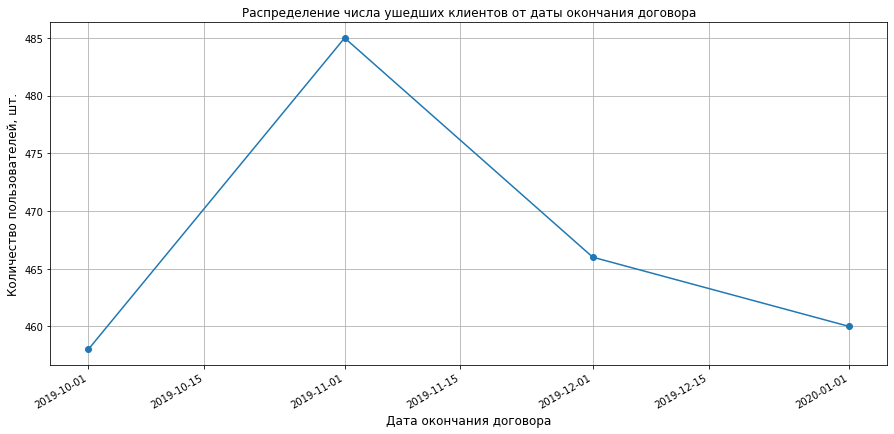

In [31]:
df.loc[df['end_date']  != '2020-02-01', 'end_date'].value_counts().plot(style='o-', grid=True,figsize=(15, 7))
plt.title('Распределение числа ушедших клиентов от даты окончания договора')
plt.xlabel('Дата окончания договора', fontsize=12)
plt.ylabel('Количество пользователей, шт.', fontsize=12)
plt.show()

На графике видим пик ушедших клиентов в ноябре 2019 года, возможно в этот период увеличилась стоимость услуг, после чего клиенты уходили. Посмотрим теперь на распределение числа новых клиентов:

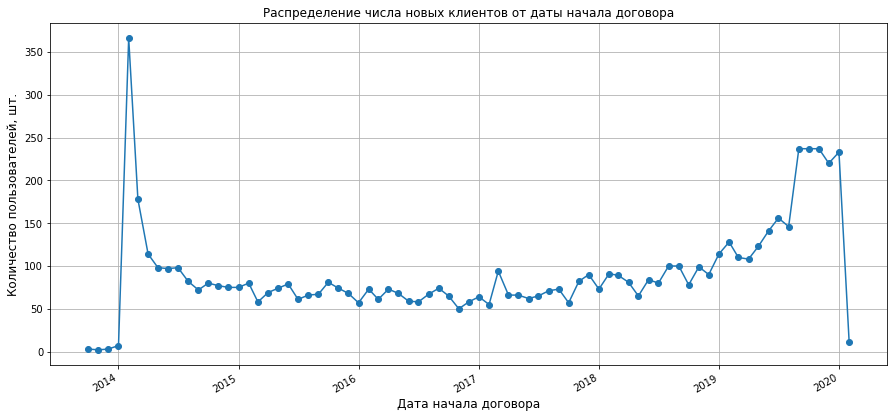

In [32]:
df['begin_date'].value_counts().plot(style='o-', grid=True,figsize=(15, 7))
plt.title('Распределение числа новых клиентов от даты начала договора')
plt.xlabel('Дата начала договора', fontsize=12)
plt.ylabel('Количество пользователей, шт.', fontsize=12)
plt.show()

На графике видим резкий рост числа пользователей в начале 2014 года, скорее всего это связано с рекламными акциями для привлечения новых клиентов. Далее идет равномерный рост числа пользователей до середины 2019 года - около 80 клиентов в месяц. Резкое падение числа новых клиентов в феврале 2020 года связано с тем, что выгрузка данных проводилась 1 февраля 2020 года.

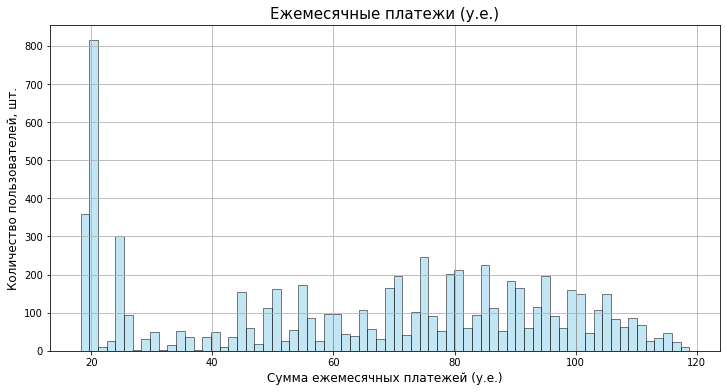

In [33]:
df['monthly_charges'].plot(kind='hist',
                           alpha=.5,
                           figsize=(12, 6),
                           grid=True,
                           bins=70,
                           color="skyblue",
                           edgecolor="black")
plt.title('Ежемесячные платежи (у.е.)', fontsize=15, y=1)
plt.xlabel('Сумма ежемесячных платежей (у.е.)', fontsize=12)
plt.ylabel('Количество пользователей, шт.', fontsize=12)
plt.show()

In [34]:
df['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

На графике мы видим, что клиенты предпочитают пользоваться дешевыми услугами.

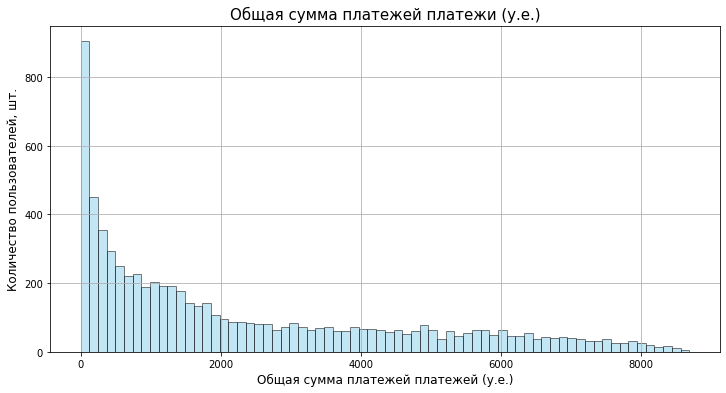

In [35]:
df['total_charges'].plot(kind='hist',
                           alpha=.5,
                           figsize=(12, 6),
                           grid=True,
                           bins=70,
                           color="skyblue",
                           edgecolor="black")
plt.title('Общая сумма платежей платежи (у.е.)', fontsize=15, y=1)
plt.xlabel('Общая сумма платежей платежей (у.е.)', fontsize=12)
plt.ylabel('Количество пользователей, шт.', fontsize=12)
plt.show()

In [36]:
df['total_charges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

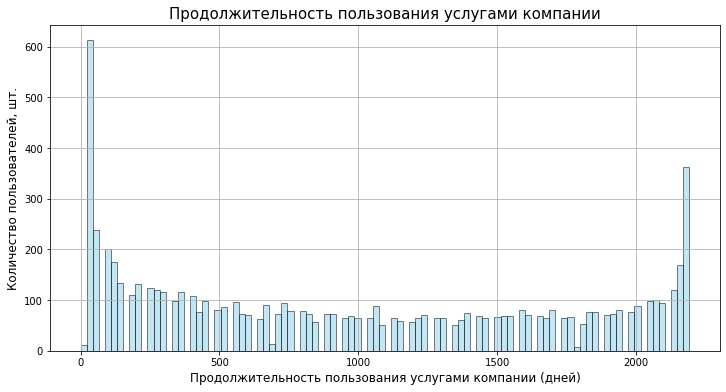

In [37]:
df['duration'].plot(kind='hist',
                           alpha=.5,
                           figsize=(12, 6),
                           grid=True,
                           bins=100,
                           color="skyblue",
                           edgecolor="black")
plt.title('Продолжительность пользования услугами компании', fontsize=15, y=1)
plt.xlabel('Продолжительность пользования услугами компании (дней)', fontsize=12)
plt.ylabel('Количество пользователей, шт.', fontsize=12)
plt.show()

In [38]:
df['duration'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: duration, dtype: float64

На графике мы видим, что многие клиенты пользуются услугами менее 100 дней. Также видим, что есть преданные клиенты, которые годами пользуются услугами компании.

# Отбор и подготовка признаков
Удалим столбцы с датой из таблицы, чтобы избежать утечки данных:

In [39]:
df = df.drop(['begin_date', 'end_date'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

Проверим количественные признаки на мультиколлинеарность

In [40]:
numeric = ['monthly_charges', 'total_charges', 'duration']

In [41]:
corr_matrix = df[numeric].corr()
corr_matrix

,monthly_charges,total_charges,duration
monthly_charges,1.000000,0.651174,0.247754
total_charges,0.651174,1.000000,0.826109
duration,0.247754,0.826109,1.000000


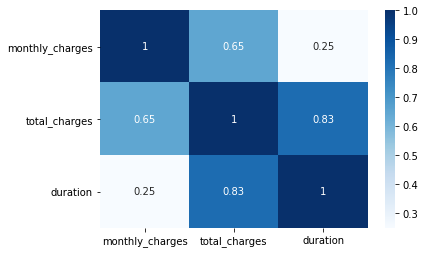

In [42]:
sbn.heatmap(corr_matrix, 
            annot=True, 
            cmap='Blues')
plt.show()

Наблюдаем сильную корреляцию 0,83 между признаками "Общая сумма оплаты" и "Продолжительность пользования услугами компании". Довольно логично - чем дольше клиент пользуется услугами, тем больше общая сумма, которую он приносит компании. Удалим признак "Общая сумма оплаты":

In [43]:
df = df.drop('total_charges', 1)

Осталось два количественных признака:

In [44]:
numeric = ['monthly_charges', 'duration']

Категориальные признаки преобразуем с помощью метода One-Hot Encoding:

In [45]:
df_ohe=pd.get_dummies(df, drop_first=True)
df_ohe.sample(5).T

customerID,5397-TUPSH,1915-IOFGU,4299-SIMNS,0924-BJCRC,3301-VKTGC
monthly_charges,70.95,70.5,81.15,89.45,85.5
senior_citizen,1.00,0.0,0.00,1.00,0.0
customer_loss,0.00,1.0,0.00,0.00,0.0
duration,1979.00,30.0,276.00,1826.00,2071.0
type_One year,1.00,0.0,0.00,0.00,1.0
type_Two year,0.00,0.0,0.00,0.00,0.0
paperless_billing_Yes,1.00,0.0,1.00,0.00,1.0
payment_method_Credit card (automatic),0.00,0.0,0.00,0.00,0.0
payment_method_Electronic check,0.00,1.0,1.00,1.00,0.0
payment_method_Mailed check,0.00,0.0,0.00,0.00,0.0


Признаки подготовили, переходим к обучению моделей.

# Обучение моделей

Выделим признаки и целевой признак в разные переменные:

In [46]:
features = df_ohe.drop(['customer_loss'], axis=1)
target = df_ohe['customer_loss']

Разделим данные на обучающую и тестовую выборки в соотношении 80:20

In [47]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=250722)

Приведём численные признаки к одному масштабу.

In [48]:
numeric = ['monthly_charges', 'duration']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

(5634, 21)
(1409, 21)


Удалим лишние переменные, чтобы освободить память и вычислительные мощности для более быстрого обучения:

In [49]:
del df_ohe
del features
del target

## Модель логистической регрессии

In [50]:
%%time
# инициализируем модель
logreg = LogisticRegression(random_state = 250722, class_weight = 'balanced')

# задаем параметры для модуля GridSearch
param_grid = {'C': [10,100], 'solver':['liblinear', 'saga'], 'max_iter':[100,200]}

# ищем лучшие параметры 
logreg_grid = GridSearchCV(logreg, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

# обучаем модель на тренировочных данных
logreg_grid.fit(features_train, target_train)

# получаем лучшие параметры модели
print()
print('Лучшие параметры модели логистической регрессии:', logreg_grid.best_params_)
print()

# получаем оценку ROC_AUC
print('ROC_AUC модели логистической регрессии на тренировочной выборке:', logreg_grid.best_score_.round(2))
print()


Лучшие параметры модели логистической регрессии: {'C': 100, 'max_iter': 100, 'solver': 'saga'}

ROC_AUC модели логистической регрессии на тренировочной выборке: 0.84

CPU times: total: 219 ms
Wall time: 2.03 s


## Модель решающего дерева

In [51]:
%%time

# инициализируем модель
dt = DecisionTreeClassifier(random_state=250722, class_weight = 'balanced')

# задаем параметры для модуля GridSearch 
param_grid = {'max_depth': [1, 10, 20], 'min_samples_split': [8, 10, 12, 14, 16]}

# ищем лучшие параметры 
dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid, cv= 5, n_jobs = -1, scoring = 'roc_auc') 

# обучаем модель на тренировочных данных
dt_grid.fit(features_train, target_train)

# получаем лучшие параметры модели
print()
print('Лучшие параметры модели решающего дерева:', dt_grid.best_params_)
print()

# получаем оценку ROC_AUC
print('ROC_AUC модели решающего дерева на тренировочной выборке:', dt_grid.best_score_.round(2))
print()


Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 16}

ROC_AUC модели решающего дерева на тренировочной выборке: 0.83

CPU times: total: 234 ms
Wall time: 429 ms


## Случайный лес

In [52]:
%%time

# инициализируем модель
rf = RandomForestClassifier(random_state=250722, class_weight = None)

# задаем параметры для модуля GridSearch 
param_grid = {'max_depth': [1, 10, 20], 'n_estimators': [100, 200]}

# ищем лучшие параметры 
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv= 5, n_jobs = -1, scoring = 'roc_auc') 

# обучаем модель на тренировочных данных
rf_grid.fit(features_train, target_train)

# получаем лучшие параметры модели
print()
print('Лучшие параметры модели случайного леса:', rf_grid.best_params_)
print()

# получаем оценку ROC_AUC
print('ROC_AUC модели случайного леса на тренировочной выборке:', rf_grid.best_score_.round(2))
print()


Лучшие параметры модели случайного леса: {'max_depth': 10, 'n_estimators': 200}

ROC_AUC модели случайного леса на тренировочной выборке: 0.85

CPU times: total: 781 ms
Wall time: 3.42 s


## LightGBM

Для модели градиентного бустинга не подойдут кодированные признаки, поэтому поменяем тип данных в категориальных признаках, для этого создадим копию исходного датасета:

In [53]:
df_lgbm = df.copy()

In [54]:
# меняем тип данных на category
categorial_columns = ['type', 
            'paperless_billing', 
            'payment_method', 
            'gender', 'senior_citizen', 
            'partner', 
            'dependents', 
            'internet_service', 
            'online_security', 
            'online_backup', 
            'device_protection', 
            'tech_support', 
            'streaming_tv', 
            'streaming_movies', 
            'multiple_lines']
df_lgbm[categorial_columns] = df_lgbm[categorial_columns].astype('category')
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   gender             7043 non-null   category
 5   senior_citizen     7043 non-null   category
 6   partner            7043 non-null   category
 7   dependents         7043 non-null   category
 8   internet_service   7043 non-null   category
 9   online_security    7043 non-null   category
 10  online_backup      7043 non-null   category
 11  device_protection  7043 non-null   category
 12  tech_support       7043 non-null   category
 13  streaming_tv       7043 non-null   category
 14  streaming_movies   7043 non-null   category
 15  multiple_lines     7043 non-null   category
 

In [55]:
features_lgbm = df_lgbm.drop(['customer_loss'], axis=1)
target_lgbm = df_lgbm['customer_loss']

Разделим данные на обучающую и тестовую выборки в соотношении 80:20

In [56]:
features_train_lgbm, features_test_lgbm, target_train_lgbm, target_test_lgbm = train_test_split(features_lgbm, 
                                                                            target_lgbm, 
                                                                            test_size=0.2, 
                                                                            random_state=250722)

Приведём численные признаки к одному масштабу:

In [57]:
numeric = ['monthly_charges', 'duration']

scaler = StandardScaler()
scaler.fit(features_train_lgbm[numeric])
features_train_lgbm[numeric] = scaler.transform(features_train_lgbm[numeric])
features_test_lgbm[numeric] = scaler.transform(features_test_lgbm[numeric])

Удалим лишние переменные, чтобы освободить память и вычислительные мощности для более быстрого обучения:

In [58]:
del df_lgbm
del features_lgbm
del target_lgbm

In [59]:
%%time
# инициализируем модель
model = LGBMClassifier(random_state=250722, class_weight = 'balanced')

# задаем параметры для модуля GridSearch 
param_grid = {'num_leaves': range(20, 60, 20),
              'max_depth': range(10, 31, 10),
              'n_estimators': range(10, 51, 10), 
              'learning_rate': [0.01, 0.1, 0.3]}
  
# ищем лучшие параметры 
lgbm_model = GridSearchCV(estimator = model, param_grid = param_grid, cv= 5, n_jobs = -1, scoring= 'roc_auc', verbose = 10) 

# обучаем модель на тренировочных данных
lgbm_model.fit(features_train_lgbm, target_train_lgbm)

# получаем лучшие параметры модели
print()
print('Лучшие параметры модели LGBMC:', lgbm_model.best_params_)
print()

# # получаем оценку ROC_AUC
print('ROC_AUC модели LGBMC на тренировочной выборке:', lgbm_model.best_score_.round(2))
print()

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Лучшие параметры модели LGBMC: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 20}

ROC_AUC модели LGBMC на тренировочной выборке: 0.9

CPU times: total: 1.73 s
Wall time: 7.39 s


# Анализ моделей

Создадим пустые списки:
* значение метрики ROC_AUC,
* значение метрики accuracy:

In [60]:
roc_auc_test = []
accuracy_test = []

Обучим модели на тестовых выборках, найдем для каждой модели нужные метрики качества:

## Модель логистической регрессии
Лучшие параметры модели логистической регрессии: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}

In [61]:
lr = LogisticRegression(random_state = 250722, class_weight = 'balanced', C = 10, max_iter = 100, solver = 'liblinear')

# обучаем модель на тренировочной выборке
lr.fit(features_train, target_train) 

# находим предсказания на тестовой выборке
predictions_test = lr.predict(features_test)

# находим вероятности класса "1"
probabilities_test = lr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# находим метрику auc_roc и accuracy
roc_auc_lr = roc_auc_score(target_test, probabilities_one_test)
roc_auc_test.append(roc_auc_lr.round(2))
accuracy_lr = accuracy_score(target_test, predictions_test)
accuracy_test.append(accuracy_lr.round(2))

print('ROC-AUC модели логистической регрессии на тестовой выборке:', roc_auc_lr.round(2))
print()
print('Accuracy модели логистической регрессии на тестовой выборке:', accuracy_lr.round(2))
print()

ROC-AUC модели логистической регрессии на тестовой выборке: 0.85

Accuracy модели логистической регрессии на тестовой выборке: 0.76



## Модель решающего дерева
Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 16}

In [62]:
dt = DecisionTreeClassifier(random_state=250722, class_weight = 'balanced', max_depth = 10, min_samples_split = 16)

# обучаем модель на тренировочной выборке
dt.fit(features_train, target_train) 

# находим предсказания на тестовой выборке
predictions_test = dt.predict(features_test)

# находим вероятности класса "1"
probabilities_test = dt.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# находим метрику auc_roc и accuracy
roc_auc_dt = roc_auc_score(target_test, probabilities_one_test)
roc_auc_test.append(roc_auc_dt.round(2))
accuracy_dt = accuracy_score(target_test, predictions_test)
accuracy_test.append(accuracy_dt.round(2))

print('ROC-AUC модели решающего дерева на тестовой выборке:', roc_auc_dt.round(2))
print()
print('Accuracy модели решающего дерева на тестовой выборке:', accuracy_dt.round(2))
print()

ROC-AUC модели решающего дерева на тестовой выборке: 0.83

Accuracy модели решающего дерева на тестовой выборке: 0.76



## Модель случайного леса
Лучшие параметры модели случайного леса: {'max_depth': 10, 'n_estimators': 100}

In [63]:
rf = RandomForestClassifier(random_state=250722, class_weight = None, max_depth = 10, n_estimators = 100)

# обучаем модель на тренировочной выборке
rf.fit(features_train, target_train) 

# находим предсказания на тестовой выборке
predictions_test = rf.predict(features_test)

# находим вероятности класса "1"
probabilities_test = rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# находим метрику auc_roc и accuracy
roc_auc_rf = roc_auc_score(target_test, probabilities_one_test)
roc_auc_test.append(roc_auc_rf.round(2))
accuracy_rf = accuracy_score(target_test, predictions_test)
accuracy_test.append(accuracy_rf.round(2))

print('ROC-AUC модели случайного леса на тестовой выборке:', roc_auc_rf.round(2))
print()
print('Accuracy модели случайного леса на тестовой выборке:', accuracy_rf.round(2))
print()

ROC-AUC модели случайного леса на тестовой выборке: 0.87

Accuracy модели случайного леса на тестовой выборке: 0.83



## Модель LGBMClassifier
Лучшие параметры модели LGBMC: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 20}

In [64]:
model = LGBMClassifier(random_state=250722, 
                       class_weight = 'balanced', 
                       learning_rate = 0.3, 
                       max_depth = 10, 
                       n_estimators = 50, 
                       num_leaves = 20)

# обучаем модель на тренировочной выборке
model.fit(features_train_lgbm, target_train_lgbm) 

# находим предсказания на тестовой выборке
predictions_test = model.predict(features_test_lgbm)

probabilities_test = model.predict_proba(features_test_lgbm)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_lgbm = roc_auc_score(target_test_lgbm, probabilities_one_test)
roc_auc_test.append(roc_auc_lgbm.round(2))
accuracy_lgbm = accuracy_score(target_test_lgbm, predictions_test)
accuracy_test.append(accuracy_lgbm.round(2))

fpr_forest_test, tpr_forest_test, thresholds = roc_curve(target_test_lgbm, probabilities_one_test)

print('ROC-AUC модели LGBMC на тестовой выборке:', roc_auc_lgbm.round(2))
print()
print('Accuracy модели LGBMC на тестовой выборке:', accuracy_lgbm.round(2))
print()

ROC-AUC модели LGBMC на тестовой выборке: 0.91

Accuracy модели LGBMC на тестовой выборке: 0.84



Построим график ROC-кривой для модели LGBM:

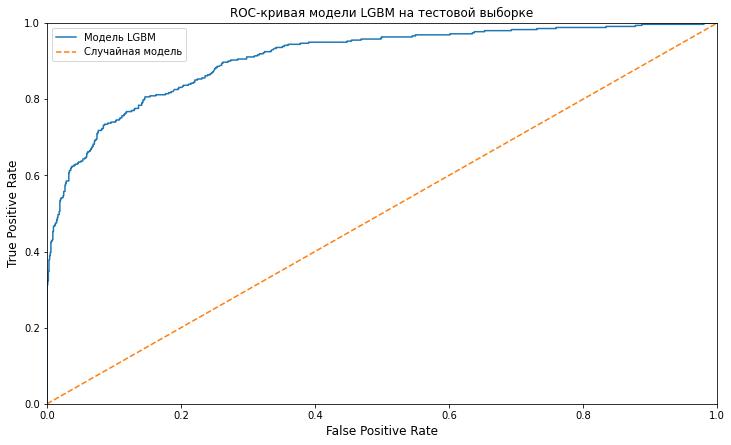

In [65]:
plt.figure(figsize=[12,7])
plt.plot(fpr_forest_test, tpr_forest_test, label = 'Модель LGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Случайная модель')

plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('ROC-кривая модели LGBM на тестовой выборке')
plt.legend()

plt.show()

Для наглядного сравнения добавим полученные данные в таблицу и сохраним ее в переменную `df_models`.

In [66]:
df_models = pd.DataFrame([roc_auc_test, accuracy_test],
             index=['Значение метрики ROC-AUC', 'Значение метрики accuracy'],
             columns=['Логистическая регрессия', 'Дерево решений', 'Случайный лес', 'LightGBMC'])
df_models.T

,Значение метрики ROC-AUC,Значение метрики accuracy
Логистическая регрессия,0.85,0.76
Дерево решений,0.83,0.76
Случайный лес,0.87,0.83
LightGBMC,0.91,0.84


Посмотрим какие признаки оказывают наибольшее влияние на отток клиентов:

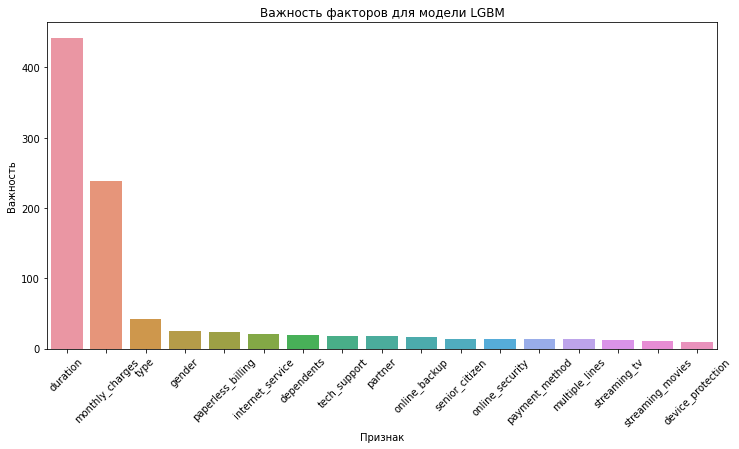

In [67]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,features_train_lgbm.columns)), columns=['Важность','Признак'])

plt.figure(figsize=(12, 6))
sbn.barplot(x="Признак", y="Важность", data=feature_imp.sort_values(by="Важность", ascending=False))
plt.title('Важность факторов для модели LGBM')
plt.xticks(rotation=45, fontsize=10) 
plt.show()

На графике видим, что наибольшее влияние на отток пользователей оказывают два признака:
* продолжительность пользования услугами компании
* сумма ежемесячных платежей

## Вывод

Мы провели тестроивание моделей, самые точные предсказания получили у модели LightGBM с гиперпараметрами:
* `learning_rate = 0.3`,
* `max_depth = 10,`
* `n_estimators = 50`,
* `num_leaves = 20`.  

При этом все модели удовлетворяют минимальным требованиям задачи ROC_AUC >= 0.75.

# Общий вывод

Объект нашего исследования - данные оператора связи «Ниединогоразрыва.ком»: 
1. информация о договорах,  
2. персональные данные клиентов,
3. информация об интернет-услугах,
4. информация об услугах телефонии.

В ходе предобработки мы подготовили данные к моделированию:
- исправили заголовки, чтобы упростить работу с таблицами,
- объединили данные, полученные из разных источников в одну таблицу,
- изменили типы данных,
- заполнили пропущенные значения.

Для решения поставленной задачи мы создали копию исходного датасета, закодировали категориальные признаки, разделили данные на две выборки:
1. обучающую (80%),
2. тестовую (20%).

Обучили и проверили модели логистической регрессии, решающего дерева и случайного леса.

Для обучения модели градиентного бустинга LightGBM мы создали копию исходного датасета, изменили тип данных в столбцах с категориальными признаками, разделили разделили данные на две выборки:
1. обучающую (80%),
2. тестовую (20%).

По результатам обучения мы проверили все модели на тестовых выборках. Самые точные предсказания получили с помощью модели LightGBM, для которой значение метрики ROC_AUC на тестовой выборке = 0,91. 

Подведём итог нашей работы - рекомендация для оператора связи «Ниединогоразрыва.ком»:
1. обратить внимание на пользователей, которые перестают пользоваться услугами менее чем через 100 дней после заключения договора, возможно причина в условиях рекламных кампаний для привлечения новых пользователей;

2. проанализировать события в ноябре 2019 года, когда наблюдается пик ухода пользователей, выяснить возможные причины;

3. для прогнозирования оттока клиентов и удержания их с помощью промокодов и специальных условий, использовать модель градиентного бустинга LightGBM с характеристиками:
    * learning_rate = 0.3
    * max_depth = 10
    * n_estimators = 50
    * num_leaves = 20. 

# Отчёт по проекту "Прогнозирование оттока клиентов" для оператора связи «Ниединогоразрыва.ком» 

В ходе работы мы чётко следовали намеченному плану, выполнили каждый пункт:
1. Изучили и предобработали данные, провели исследовательский анализ данных
2. Отобрали и подготовили признаки
3. Разделили данные на выборки, подобрали гиперпараметры моделей, обучили модели
4. Проанализировали результаты работы моделей
5. Сделали вывод

Важно отметить, что без трудностей не обошлось. Исследовательский анализ данных и отбор признаков - самые важные и трудные пункты плана. Для решения этих задач мы использовали различные инструменты:
* средствами библиотеки `matplotlib.pyplot` мы строили наглядные графики для визуализации данных об ушедших клиентах
* проверили данные на мультиколлинеарность признаков и удалили признак, сильно коррелирующий с другим признаком
* категориальные признаки кодировали методом One-Hot Encoding.

Стоит сделать акцент на ключевых шагах в решении задачи:
- четкое следование плану
- внимательное изучение данных
- подготовка данных к обучению моделей
- подбор гиперпараметров моделей при обучении
- обучение и анализ разных моделей.

В результате проведенной работы мы получили итоговую модель для прогнозирования оттока клиентов оператора связи "Ниединогоразрыва.ком". Лучший результат для модели градиентного бустинга LGBM на тестовой выборке - значение метрики ROC-AUC 0.91 и значение метрики accuracy 0.84.